# Use-case: forecasting diffusion of innovations


**Diffusion of innovations** is a theory that seeks to explain how, why, and at what rate new ideas and technology spread through cultures. This theory was formulated by E.M. Rogers in 1962 and is often used to understand the adoption or spread of new products and technologies among different groups of people. 

An innovation is something new or significantly improved. This can include products, ideas, or practices that are perceived as new by an individual or other unit of adoption. Diffusion refers to the process by which an innovation is communicated over time among the participants in a social system.

The diffusion of innovations theory applies to a variety of new ideas. Here are a few examples:

## Examples of Processes Following Diffusion of Innovations

1. **Number of new unique users**: The number of new unique users of a product or service can be modeled using the diffusion of innovations theory. This can help businesses forecast their growth and plan for future expansion.

2. **Technology Adoption**: Perhaps the most common application of the theory, technology adoption refers to how new gadgets, software, or platforms spread among users. For instance, the adoption of smartphones followed this diffusion process, starting with innovators and tech enthusiasts before reaching the broader public.

3. **Healthcare Practices**: New medical practices, treatments, or health campaigns spread among medical professionals and the public using the diffusion framework. An example could be the adoption of telemedicine, which has seen increased acceptance over recent years.

4. **Sustainable Practices**: The adoption of renewable energy sources like solar panels or wind turbines often follows the diffusion of innovations model. Innovators begin by testing and using these technologies, which gradually become more mainstream as their advantages and efficiencies are recognized.

5. **Agricultural Techniques**: New farming technologies or methods, such as hydroponics or genetically modified crops, also spread through agricultural communities by following the principles of diffusion of innovations.

## The Bell-Shaped Curve

The diffusion of innovations can be visualized using a bell-shaped curve, often called the "diffusion curve." This curve is crucial for understanding the rate at which new ideas and technologies are adopted in a society. Here's how it aligns with the categories of adopters:

- **Innovators** make up the first small section on the left of the curve. These are the first few who adopt the innovation.
- **Early Adopters** follow next and represent a slightly larger segment as the curve starts to ascend.
- **Early Majority** forms the first large segment of the curve, where it reaches and crosses the mean. Adoption is becoming more common and widespread here.
- **Late Majority** comes next, at the point where the curve starts to descend. This group adopts just as the new idea or technology begins to feel outdated.
- **Laggards** are the last segment, where the curve tails off. Adoption within this group occurs very slowly and often only when necessary.

The bell-shaped curve reflects the cumulative adoption of innovations over time, demonstrating that the speed of adoption typically starts slow, accelerates until it reaches the majority of the potential market, and then slows down as fewer non-adopters remain.

This curve is central to strategic decisions in marketing, product development, and policy-making, helping stakeholders identify when and how to best introduce new ideas or technologies to different segments of society.

## The dataset

As a proxy for diffusion of innovations, we will use the number of stars received by Tensorflow Repository over time. Although this is not a perfect measure of adoption, it can give us an idea of how the popularity of the repository has grown since its inception. 

This repository had an initial explosion of stars during the first ~10 days, which we will ignore since the daily granularity is not enough to capture the initial growth (hourly might work). After that, the number of starts grew by following a bell-shaped curve, which we will try to model. This curve might be related to the popularity of deep learning itself.

```{info}

This dataset was obtained from https://github.com/emanuelef/daily-stars-explorer. 

```



/var/folders/vf/2lwdd44x19jd7fsyrzczzsd5dr_gjn/T/ipykernel_3422/585802412.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/vf/2lwdd44x19jd7fsyrzczzsd5dr_gjn/T/ipykernel_3422/585802412.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


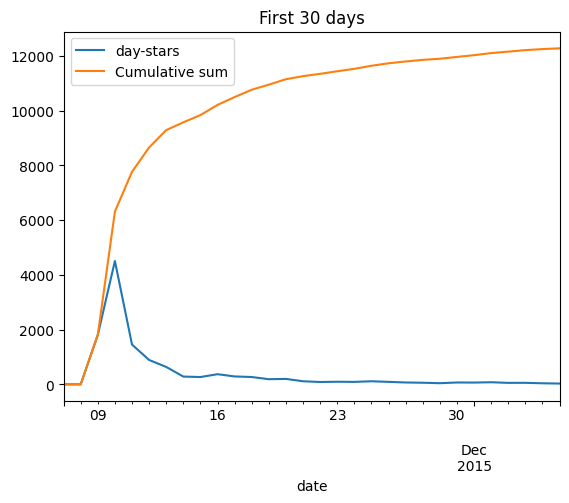

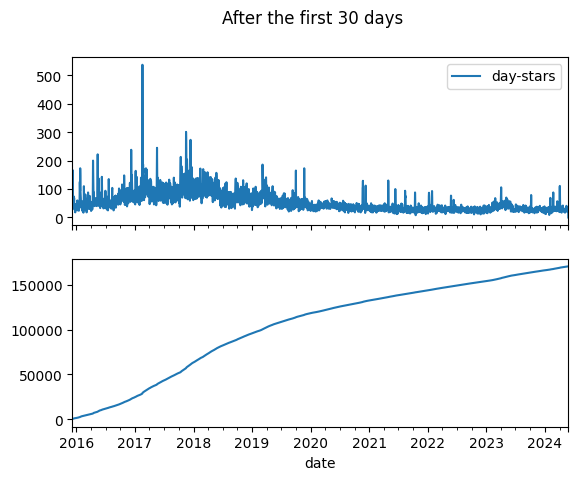

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("tensorflow_tensorflow-stars-history.csv")
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y").dt.to_period("D")
df = df.set_index("date")
df = df.sort_index()
y = df[["day-stars"]]


fig, ax = plt.subplots()
# First 30 days
y.iloc[:30].plot.line(ax=ax)
y.iloc[:30].cumsum()["day-stars"].rename("Cumulative sum").plot.line(ax=ax, legend=True)
ax.set_title("First 30 days")
fig.show()

fig, axs = plt.subplots(nrows=2, sharex=True)
y.iloc[30:].plot.line(ax=axs[0])
y.iloc[30:].cumsum()["day-stars"].rename("Cumulative sum").plot.line(ax=axs[1])
# FIgure title
fig.suptitle("After the first 30 days")
fig.show()



## Modeling the Diffusion of Innovations

To model this behaviour with Prophetverse, we will use the custom trend feature. 

We will define a trend model class that implements the generalized logistic curve, which accepts assymetric curves. We will also add another premise: a varying capacity, which will allow us to model a linear growth of the total addressable market (TAM) over time.  Let $G(t)$ be the logistic curve defining the acumulated number of stars at time $t$:

$$
\begin{align*}
G(t) &= \frac{C_1(t-t_0) + C_2}{\left(1 + \exp(-\alpha v (t - t_0))\right)^{\frac{1}{v}}} \\
\text{where} & \\

C_2 \in \mathbb{R}_+ &= \text{is the constant capacity term}\\
C_1 \in \mathbb{R}_+ &= \text{is the linear increasing rate of the capacity}\\
t_0 \in \mathbb{R} &= \text{is the time offset term}\\
v \in \mathbb{R}_+ &= \text{determines the shape of the curve} \\
\alpha \in \mathbb{R} &= \text{is the rate}
\end{align*}
$$

It's derivative is:

$$
\begin{align*}
g(t) &= \alpha\left(1 - \frac{G(T)}{C_1(t-t_0) + C_2}\right) G(T)  + \frac{C_1}{C_1(t-t_0) + C_2}G(T) \\
\end{align*}
$$

That curve can be used as trend to model a diffusion process.
Below, we plot it for a combination of parameters

/var/folders/vf/2lwdd44x19jd7fsyrzczzsd5dr_gjn/T/ipykernel_3422/2552955637.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


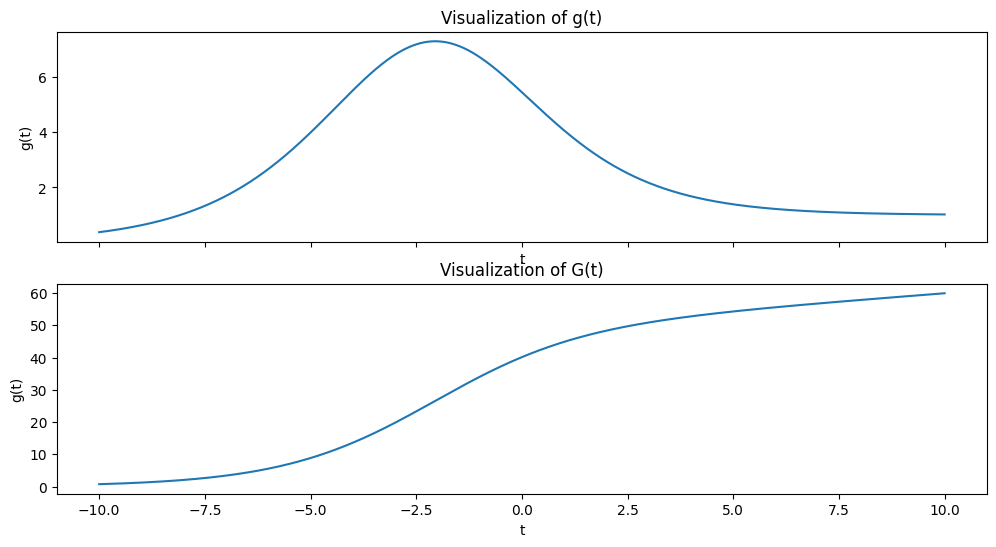

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os


def g(t, C1, C2, t0, v, alpha):
    return (C1 * (t - t0) + C2) / ((1 + np.exp(-alpha * v * (t - t0))) ** (1 / v))


def normalized_generalized_logistic(x, A, v, t0):
    return 1 / (1 + np.exp(-A * v * (x - t0))) ** (1 / v)


# Define the generalized logistic function
def generalized_logistic(x, C1, C2, alpha, v, t0):
    return (C1 * x + C2) * normalized_generalized_logistic(x, alpha, v, t0)


def dgeneralized_logistic(x, C1, C2, alpha, v, t0):
    return alpha * (
        1 - (generalized_logistic(x, C1, C2, alpha, v, t0) / (C1 * x + C2)) ** v
    ) * generalized_logistic(
        x, C1, C2, alpha, v, t0
    ) + C1 * normalized_generalized_logistic(
        x, alpha, v, t0
    )

C1= 1
C2 = 50
t0 = -2
v= 1.2
alpha = 0.5
label = (f"C1={C1:.1f}, C2={C2:.1f}, t0={t0:.1f}, v={v:.1f}, alpha={alpha:.1f}",)

t = np.linspace(-10, 10, 1000)
gt = dgeneralized_logistic(t, C1=C1, C2=C2, t0=t0, v=v, alpha=alpha)

fig, axs = plt.subplots(figsize=(12, 6), nrows=2, sharex=True)
axs[0].plot(
    t,
    gt,
    label=label,
)
axs[0].set_title("Visualization of g(t)")
axs[0].set_xlabel("t")
axs[0].set_ylabel("g(t)")

#axs[0].grid(True)

Gt = generalized_logistic(t, C1=C1, C2=C2, t0=t0, v=v, alpha=alpha)
axs[1].plot(
    t,
    Gt,
    label=label,
)
axs[1].set_title("Visualization of G(t)")
axs[1].set_xlabel("t")
axs[1].set_ylabel("g(t)")

#axs[1].grid(True, alpha=0.3)
fig.show()

That curve has the bell-shape and the flexiblity to not be symmetric depending on the parameters. Furthermore, it tends to a constant value ($C1$) as time goes to infinity, which represent our knowledge that the size of the "market" of tensorflow/neural networks users starts at a value and grows with time.

## Splitting the dataset

We leave 7 years to forecast, and 1.5 year to train. Note that, without the prior information on the nature of the curve, a model could simply forecast a linear growth of the number of stars, which would be a very poor forecast. 

In [3]:
split_at = -int(365 * 7)
y = y.iloc[20:]
y_train, y_test = y.iloc[:split_at], y.iloc[split_at:]

Text(0.5, 0.98, 'Tensorflow Stars')

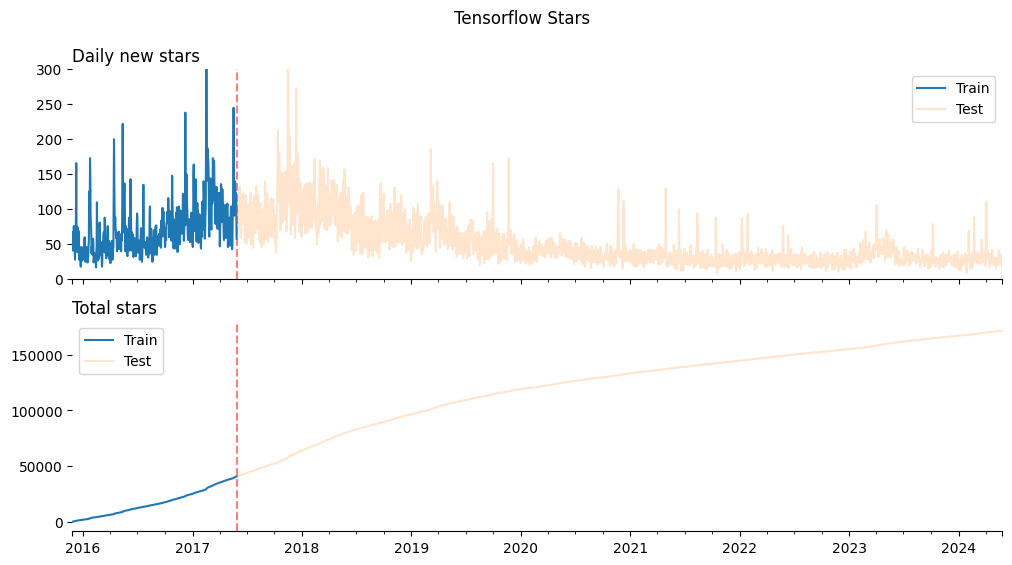

In [4]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
ax = axs[0]
ax = y_train["day-stars"].rename("Train").plot.line(legend=True, ax=ax)
y_test["day-stars"].rename("Test").plot.line(ax=ax, alpha=0.2, legend=True)
ax.axvline(y_train.index[-1], color="red", linestyle="--", alpha=0.5, zorder=-1)
ax.set_title("Daily new stars", loc="left")
ax.set_xlabel("")
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlim(y.index.min(), y.index.max())
ax.set_ylim(0, 300)

ax = axs[1]
ax = y_train["day-stars"].rename("Train").cumsum().plot.line(legend=True)
(
    y_test["day-stars"].rename("Test").cumsum()
    + y_train["day-stars"].rename("Train").cumsum().max()
).plot.line(ax=ax, alpha=0.2, legend=True)
ax.axvline(y_train.index[-1], color="red", linestyle="--", alpha=0.5, zorder=-1)
ax.set_title("Total stars", loc="left")
ax.set_xlabel("")
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
# Superior
ax.spines["top"].set_visible(False)
ax.set_xlim(y.index.min(), y.index.max())

fig.suptitle("Tensorflow Stars")

## Creating the custom trend

To create a custom trend model for use in the Prophetverse library, users can extend the TrendModel abstract base class and implement the required abstract methods. Here’s a step-by-step guide to create a custom trend model, using the GenLogisticTrend class as an example.


### Step 1: Define helper functions

The GenLogisticTrend class will use the following helper functions:

In [5]:
import jax.numpy as jnp
import jax



@jax.jit
def normalized_generalized_logistic(x, A, v, t0):
    return 1 / (1 + jnp.exp(-A * v * (x - t0))) ** (1 / v)


@jax.jit
def dnormalized_generalized_logistic(x, A, v, t0):
    return (
        A
        * (1 - normalized_generalized_logistic(x, A, v, t0) ** v)
        * normalized_generalized_logistic(x, A, v, t0)
    )


# Define the generalized logistic function

@jax.jit
def dgeneralized_logistic(x, K1, K2, A, v, M):
    return dnormalized_generalized_logistic(x, A, v, M) * (
        K1 * x + K2
    ) + K1 * normalized_generalized_logistic(x, A, v, M)

### Step 2: Define the Custom Trend Model Class

Create a new class that extends the TrendModel abstract base class. Implement the abstract methods initialize, prepare_input_data, and compute_trend.

In [6]:
from prophetverse.trend.base import TrendModel
import numpyro
from numpyro import distributions as dist
from prophetverse.utils.frame_to_array import convert_index_to_days_since_epoch



class GenLogisticTrend(TrendModel):
    """
    Custom trend model based on the Generalized Logistic function.
    """

    def initialize(self, y: pd.DataFrame):
        """
        Initialize the trend model.
        
        Here we receive the y data (training) and we can compute any necessary pre-processing steps.

        Args:
            y (pd.DataFrame): The input time series data.

        Returns:
            None
        """
        t = convert_index_to_days_since_epoch(y.index)
        self.t_min_ = t.min()
        t = t - self.t_min_

    def prepare_input_data(self, idx: pd.PeriodIndex) -> dict:
        """
        Prepare the input data for trend computation.
        
        This method is called at train and predict time to prepare the input data for trend computation.

        Args:
            idx (pd.PeriodIndex): The index of the time series data.

        Returns:
            dict: The prepared input data.
        """
        t = convert_index_to_days_since_epoch(idx)
        t = t - self.t_min_
        self.offset_prior_loc = len(idx)
        return {"time": t}

    def compute_trend(self, time):
        """
        Compute the trend based on the Generalized Logistic function.

        Args:
            time: The time values.

        Returns:
            numpy.ndarray: The computed trend values.
        """
        
        logistic_rate, logistic_capacity1, logistic_capacity2, shape, offset = self._sample_params()

        trend = dgeneralized_logistic(
            time,
            K1=logistic_capacity1,
            K2=logistic_capacity2,
            A=logistic_rate,
            v=shape,
            M=offset,
        )

        numpyro.deterministic("__trend", trend)
        
        numpyro.deterministic("capacity", logistic_capacity1*(time-offset) + logistic_capacity2)

        return trend.reshape((-1, 1))

    def _sample_params(self):
        """
        Sample parameters for the custom trend model.

        Returns:
            Tuple: A tuple containing the sampled parameters:
                - logistic_rate (float): The rate parameter for the logistic distribution.
                - logistic_capacity1 (float): The capacity parameter for the first logistic distribution.
                - logistic_capacity2 (float): The capacity parameter for the second logistic distribution.
                - shape (float): The shape parameter for the logistic distribution.
                - offset (float): The offset parameter for the normal distribution.
        """
        logistic_rate = numpyro.sample("logistic_rate", dist.Normal(0.01, 0.01))

        logistic_capacity1 = numpyro.sample(
            "logistic_capacity",
            dist.Gamma(15, 1),
        )

        logistic_capacity2 = numpyro.sample(
            "logistic_capacity2",
            dist.HalfNormal(80_000),
        )

        shape = numpyro.sample("logistic_shape", dist.Gamma(1, 1))

        offset = numpyro.sample(
            "offset",
            dist.Normal(loc=self.offset_prior_loc, scale=365 * 2),
        )
        
        return logistic_rate, logistic_capacity1, logistic_capacity2, shape, offset



## Fit the model and make predictions

In [7]:
from prophetverse.sktime import Prophetverse
from sktime.transformations.series.fourier import FourierFeatures
from prophetverse.effects.linear import LinearEffect
from prophetverse.utils.regex import starts_with
import numpyro

numpyro.enable_x64()

model = Prophetverse(
    trend=GenLogisticTrend(),
    inference_method="mcmc",
    feature_transformer=FourierFeatures(
        sp_list=[7, 365.25],
        fourier_terms_list=[3, 8],
        freq="D",
        keep_original_columns=True,
    ),
    exogenous_effects=[
        LinearEffect(
            id="seasonality",
            prior=dist.Normal(0, 0.1),
            effect_mode="multiplicative",
            regex=starts_with(["sin", "cos"]),
        )
    ],
    likelihood="negbinomial",
    mcmc_samples=500,
    mcmc_warmup=1000,
    scale=1,
    noise_scale=20,
)

model.fit(y_train)

sample: 100%|██████████| 1500/1500 [01:18<00:00, 19.14it/s, 255 steps of size 1.48e-02. acc. prob=0.91]


Prophetverse(exogenous_effects=[<prophetverse.effects.LinearEffect object at 0x3088b82d0>],
             feature_transformer=FourierFeatures(fourier_terms_list=[3, 8],
                                                 freq='D',
                                                 keep_original_columns=True,
                                                 sp_list=[7, 365.25]),
             inference_method='mcmc', likelihood='negbinomial',
             mcmc_samples=500, mcmc_warmup=1000, noise_scale=20, scale=1,
             trend=<__main__.GenLogisticTrend object at 0x120c2b610>)

In [8]:
import matplotlib.pyplot as plt
fh = pd.period_range(y.index.min(), "2026-01-01")
preds = model.predict(fh=fh)
interval = model.predict_interval(
    fh=fh,
    coverage=0.9,
)
display(preds.head())

,day-stars
2015-11-27,54.048
2015-11-28,40.796
2015-11-29,40.852
2015-11-30,54.778
2015-12-01,56.596


In [9]:
interval.columns = interval.columns.droplevel([0, 1])
interval.head()

,lower,upper
2015-11-27,26.00,88.05
2015-11-28,17.95,66.00
2015-11-29,19.00,70.00
2015-11-30,26.95,90.15
2015-12-01,28.95,96.05


## Plotting the results

/var/folders/vf/2lwdd44x19jd7fsyrzczzsd5dr_gjn/T/ipykernel_3422/1412546182.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


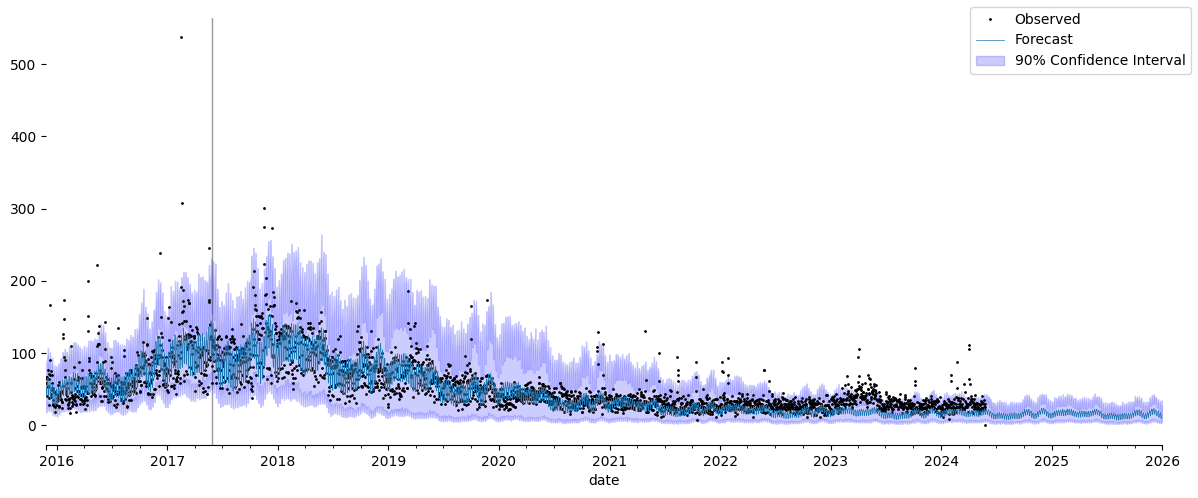

In [10]:
# Just the scatter of y, without lines
fig, ax = plt.subplots(figsize=(12, 5))
ax = y["day-stars"].rename("Observed").plot.line(marker="o", linestyle="None", legend=False, markersize=1, color="black",  ax=ax)
ax.axvline(y_train.index.max(),color="black", zorder=-1, alpha=0.4, linewidth=1)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
# Superior
ax.spines["top"].set_visible(False)

preds["day-stars"].rename("Forecast").plot.line(
    ax=ax, alpha=1, linewidth=0.5, legend=False
)

ax.fill_between(
    fh.to_timestamp(),
    interval["lower"],
    interval["upper"],
    color="blue",
    alpha=0.2,
    zorder=-1,
    label="90% Confidence Interval",
)
fig.legend()
fig.tight_layout()
fig.show()

In [11]:
# Forecast samples
yhat_samples = model.predict_samples(
    fh=fh
)
# Samples of all sites (capacity, for example, that we had set as deterministic with numpyro.deterministic)
site_samples = model.predict_all_sites_samples(fh=fh)

In [12]:
# Set number of columns to display to 4 temporarily
pd.set_option("display.max_columns", 4)
yhat_samples.head()

,0,1,...,498,499
2015-11-27,45,68,...,55,41
2015-11-28,16,58,...,72,37
2015-11-29,86,31,...,46,39
2015-11-30,100,116,...,41,51
2015-12-01,60,37,...,42,51


In [13]:
# Get quantile 0.25, 0.75 and mean
import functools


def q25(x):
    return np.quantile(x, q=0.25)

def q75(x):
    return np.quantile(x, q=0.75)


site_quantiles = site_samples.groupby(level=[-1]).agg([
        np.mean,
        q25,
        q75,
    ]

)
site_quantiles.head()

/var/folders/vf/2lwdd44x19jd7fsyrzczzsd5dr_gjn/T/ipykernel_3422/3625754022.py:12: FutureWarning: The provided callable <function mean at 0x108631c60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  site_quantiles = site_samples.groupby(level=[-1]).agg([


__trend             ...      trend           
                 mean        q25  ...        q25        q75
2015-11-27  41.731163  40.553377  ...  40.553377  42.846732
2015-11-28  41.824787  40.644299  ...  40.644299  42.933411
2015-11-29  41.918564  40.733693  ...  40.733693  43.023096
2015-11-30  42.012493  40.820667  ...  40.820667  43.118234
2015-12-01  42.106574  40.913720  ...  40.913720  43.200155

[5 rows x 15 columns]

Text(0.5, 1.0, 'Total number of stars (forecast)')

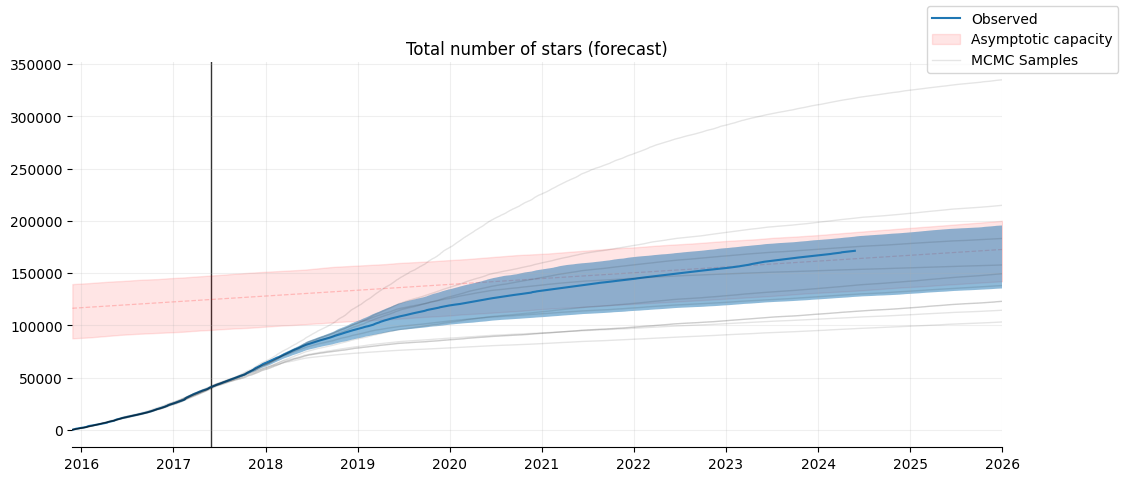

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot true value
ax.plot(y.index.to_timestamp(), y.cumsum(), label="Observed")

# Train test split
ax.axvline(y_train.index.max(), color="black", alpha=0.8, zorder=-1, linewidth=1)


# Capacity asymptotic
ax.fill_between(
    fh.to_timestamp(),
    site_quantiles.loc[:,("capacity", "q25")],
    site_quantiles.loc[:, ("capacity", "q75")],
    color="red",
    alpha=0.1,
    zorder=-1,
    label="Asymptotic capacity"
)
ax.plot(fh.to_timestamp(), site_quantiles.loc[:, ("capacity", "mean")], color="red", alpha=0.2, linestyle="--", zorder=-1,
    linewidth=0.9)


# Plot some random samples
idxs = np.random.choice(yhat_samples.columns, 10)

for i, idx in enumerate(idxs):
    kwargs={}
    if i == 0:
        kwargs["label"] = "MCMC Samples"
    ax.plot(fh.to_timestamp(), yhat_samples.cumsum().loc[:, idx], color="black", alpha=0.1, linewidth=1, **kwargs)

# ax.plot(fh.to_timestamp(), (fh.to_timestamp() - fh.to_timestamp().min()).days * capacity_mean_asymptotic + capacity_mean , color="red", alpha=0.5, linestyle="--")

upper_and_lower_cumsum = yhat_samples.cumsum().quantile([alpha / 2, 1 - alpha / 2], axis=1).T
ax.fill_between(
    upper_and_lower_cumsum.index.to_timestamp(),
    upper_and_lower_cumsum.iloc[:, 0],
    upper_and_lower_cumsum.iloc[:, 1],
    alpha=0.5,
)
ax.grid(alpha=0.2)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
# Superior
ax.spines["top"].set_visible(False)

ax.set_xlim(fh.to_timestamp().min(), fh.to_timestamp().max())

# Add samples to legend

fig.legend()
ax.set_title("Total number of stars (forecast)")